# Notebook on Featurization - Organic Molecules
By Dane Morgan with a lot of materials taken from

*  [Logan Ward's course](https://github.com/WardLT/applied-ai-for-materials/tree/main/molecular-property-prediction).
* [RDkit Cookbook](https://www.rdkit.org/docs/Cookbook.html).

Learning goal:
* To learn basic concepts about how materials systems are featurized.
* Be able to impliment a featurization and use it to predict properties in a machine learning model.

## Getting started and hints
 * Remember to click "Shift+Return" or click "Run" from the top bar to run each cell.
 * Use this file and download qm9.json.gz and put in your working directory (or uncomment the import the qm9 databases touin the "Download" section).

In [236]:
#from google.colab import drive
#drive.mount('/content/drive')

# Colab setup

Here, modify the path where you saved this notebook and the associated lab files on your Google drive, if different from below (this is an example Dane Morgan had for class)

In [237]:
path = './resources/'
#path = '/content/drive/MyDrive/Online Filed/Dane Morgan Mixed Sharing/Projects/Courses/MSE803 F22/Dane student view/MSE803_Lab1'

Check the path name is assigned correctly.

In [238]:
!echo $path
import os
os.path.isdir(path)

./resources/


True

# Environment setup

In [239]:
# This is needed so can import packages from a different path than standard libraries
import sys
sys.path.append(path)

In [240]:
# Import data (pandas, gzip, json) handling tools
import pandas as pd
import numpy as np
import cv2
import gzip
import json

#import plotting tools - matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt

In [241]:
# Import materials and chemistry specific tools

# RDKIT for basic tools for managing chemical data
#!pip install rdkit-pypi
from rdkit import Chem  # Common functionality from RDKit is available in the Chem module
from rdkit.Chem import AllChem  # Most of the other functions are in AllChem and other modules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from rdkit.Chem import rdChemReactions
from rdkit.Chem import DataStructs

# Mordred, a Python library that wraps RDKit and other codes so that they work better with the Python data and ML libraries.
#!pip install mordred
from mordred import Calculator, descriptors

# Load MASTML and its dependencies
#!pip install mastml==3.1.5
#!pip install pyyaml==5.4.1

In [242]:
# Import sklearn routines
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

# Download data needed for this work.
Can skip this if qm9.json.gz is available already.

In [243]:
'''
import pandas as pd
import os

# QM9: For this, we use the Pandas-friendly version
# from: https://github.com/globus-labs/g4mp2-atomization-energy
data = pd.read_json('https://github.com/globus-labs/g4mp2-atomization-energy/raw/master/data/output/g4mp2_data.json.gz', lines=True)
data = data.sample(25000, random_state=1)
data.to_json(os.path.join(path, 'qm9.json.gz'), orient='records', lines=True)
'''

"\nimport pandas as pd\nimport os\n\n# QM9: For this, we use the Pandas-friendly version\n# from: https://github.com/globus-labs/g4mp2-atomization-energy\ndata = pd.read_json('https://github.com/globus-labs/g4mp2-atomization-energy/raw/master/data/output/g4mp2_data.json.gz', lines=True)\ndata = data.sample(25000, random_state=1)\ndata.to_json(os.path.join(path, 'qm9.json.gz'), orient='records', lines=True)\n"

# Parsing Chemical Data
The data for our lesson is stored as line-delimited JSON, where each individual record is a dictionary that contains some information about a molecule and a name that captures the molecular structure

## Part 1: Getting the Data off Disk
We first solve a problem that has nothing to do with chemistry: reading a table into Python.

In [244]:
data_path = 'qm9.json.gz'
with gzip.open(data_path, 'rt') as fp:
    record = fp.readline().strip()
print(record)

{"A":2.5832,"B":1.30797,"C":0.93888,"R2":1313.6519,"alpha":89.34,"atomic_charges":[-0.499654,0.225168,0.200368,-0.291577,-0.21091,-0.28294,-0.105237,-0.239277,-0.322535,0.124266,0.121383,0.129916,0.102653,0.100871,0.096362,0.101769,0.097331,0.102152,0.095926,0.11547,0.111787,0.226708],"bandgap":0.2487,"cv":34.347,"filename":"dsgdb9nsd_073931.xyz","g":-367.242047,"g4mp2_0k":-366.761358,"g4mp2_atom":-3.347687,"g4mp2_energy":-366.752131,"g4mp2_enthalpy":-366.751186,"g4mp2_free":-366.795572,"g4mp2_hf298":33.0693,"g4mp2_zpe":0.192623,"h":-367.197822,"homo":-0.2266,"inchi_0":"InChI=1S\/C8H13N\/c1-6-3-2-4-7(6)8-5-9-8\/h8-9H,2-5H2,1H3","inchi_1":"InChI=1S\/C8H13N\/c1-6-3-2-4-7(6)8-5-9-8\/h8-9H,2-5H2,1H3\/t8-\/m1\/s1","index":73931,"lumo":0.0221,"mu":1.8965,"n_atom":22,"n_electrons":68,"n_heavy_atoms":9,"smiles_0":"CC1=C(CCC1)C1CN1","smiles_1":"CC1=C(CCC1)[C@H]1CN1","u":-367.198766,"u0":-367.2079,"u0_atom":-3.346314,"xyz":"22\nProperties=species:S:1:pos:R:3 unique_id=ef4cdf48825f07674198527d13d

We need to do two things to make this data usable. First, take that record and parse it into a Python dictionary.

In [245]:
json.loads(record)

{'A': 2.5832,
 'B': 1.30797,
 'C': 0.93888,
 'R2': 1313.6519,
 'alpha': 89.34,
 'atomic_charges': [-0.499654,
  0.225168,
  0.200368,
  -0.291577,
  -0.21091,
  -0.28294,
  -0.105237,
  -0.239277,
  -0.322535,
  0.124266,
  0.121383,
  0.129916,
  0.102653,
  0.100871,
  0.096362,
  0.101769,
  0.097331,
  0.102152,
  0.095926,
  0.11547,
  0.111787,
  0.226708],
 'bandgap': 0.2487,
 'cv': 34.347,
 'filename': 'dsgdb9nsd_073931.xyz',
 'g': -367.242047,
 'g4mp2_0k': -366.761358,
 'g4mp2_atom': -3.347687,
 'g4mp2_energy': -366.752131,
 'g4mp2_enthalpy': -366.751186,
 'g4mp2_free': -366.795572,
 'g4mp2_hf298': 33.0693,
 'g4mp2_zpe': 0.192623,
 'h': -367.197822,
 'homo': -0.2266,
 'inchi_0': 'InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2-5H2,1H3',
 'inchi_1': 'InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2-5H2,1H3/t8-/m1/s1',
 'index': 73931,
 'lumo': 0.0221,
 'mu': 1.8965,
 'n_atom': 22,
 'n_electrons': 68,
 'n_heavy_atoms': 9,
 'smiles_0': 'CC1=C(CCC1)C1CN1',
 'smiles_1': 'CC1=C(CCC1)[C

And, second, making it easy to work with a lot of these dictionaries at once.

For this purpose, we use [Pandas](https://pandas.pydata.org/docs/user_guide/index.html).

In [246]:
num_data_in_pandas = 1000 # Set number of data to work with for analysis. Only get the first few for simplicity.  Can get more later. Has about 130k entries I think.
data = pd.read_json(data_path, lines=True).head(num_data_in_pandas)
data.head(5)

,A,B,C,R2,alpha,atomic_charges,bandgap,cv,filename,g,...,n_electrons,n_heavy_atoms,smiles_0,smiles_1,u,u0,u0_atom,xyz,zpe,in_holdout
0,2.58320,1.30797,0.93888,1313.6519,89.34,"[-0.499654, 0.22516799999999998, 0.200368, -0....",0.2487,34.347,dsgdb9nsd_073931.xyz,-367.242047,...,68,9,CC1=C(CCC1)C1CN1,CC1=C(CCC1)[C@H]1CN1,-367.198766,-367.207900,-3.346314,22\nProperties=species:S:1:pos:R:3 unique_id=e...,0.195447,True
1,2.50363,1.68227,1.32686,1066.7017,81.18,"[-0.253992, -0.297035, 0.458459, -0.295609, -0...",0.3021,32.672,dsgdb9nsd_108342.xyz,-387.056955,...,68,9,COC12CCC1C1CC21,CO[C@]12CC[C@H]1[C@H]1C[C@@H]21,-387.016378,-387.024539,-3.182508,21\nProperties=species:S:1:pos:R:3 unique_id=f...,0.182771,True
2,6.44379,3.58724,2.94944,499.0357,52.75,"[-0.432449, 0.12344899999999999, -0.2712259999...",0.3269,21.241,dsgdb9nsd_000691.xyz,-270.425102,...,46,6,OC1CC2CC12,O[C@H]1C[C@H]2C[C@@H]12,-270.390923,-270.396464,-2.095841,14\nProperties=species:S:1:pos:R:3 unique_id=b...,0.120540,True
3,2.64044,1.67950,1.51719,1033.9676,87.26,"[-0.438222, 0.034372, -0.032073, -0.202725, -0...",0.3446,31.869,dsgdb9nsd_083515.xyz,-351.194098,...,68,9,CC1C2CCC1C1CC21,C[C@H]1[C@H]2CC[C@@H]1[C@H]1C[C@@H]21,-351.155574,-351.162962,-3.538192,23\nProperties=species:S:1:pos:R:3 unique_id=d...,0.210086,True
4,2.14542,1.65063,1.17003,1132.2185,76.29,"[-0.273371, -0.291985, 0.305875, -0.320667, -0...",0.2338,33.320,dsgdb9nsd_106542.xyz,-423.017933,...,68,9,COC12CC(C1C)C2=O,CO[C@@]12C[C@@H]([C@H]1C)C2=O,-422.975002,-422.984043,-2.924751,19\nProperties=species:S:1:pos:R:3 unique_id=a...,0.157829,True


In [247]:
data[['smiles_0', 'inchi_0', 'u']].head(5)

,smiles_0,inchi_0,u
0,CC1=C(CCC1)C1CN1,"InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2...",-367.198766
1,COC12CCC1C1CC21,InChI=1S/C8H12O/c1-9-8-3-2-6(8)5-4-7(5)8/h5-7H...,-387.016378
2,OC1CC2CC12,"InChI=1S/C5H8O/c6-5-2-3-1-4(3)5/h3-6H,1-2H2",-270.390923
3,CC1C2CCC1C1CC21,"InChI=1S/C9H14/c1-5-6-2-3-7(5)9-4-8(6)9/h5-9H,...",-351.155574
4,COC12CC(C1C)C2=O,"InChI=1S/C7H10O2/c1-4-5-3-7(4,9-2)6(5)8/h4-5H,...",-422.975002


The above commands read the file from disk ([`read_json`](https://pandas.pydata.org/docs/user_guide/io.html#json)) and then displays a fraction of the table. I display the table to show that this object represents, in a sense, a big table or digital spreadsheet.

## Part 2: Parsing Chemical Structures
The molecular structure of each record are recorded as ["SMILES"](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) and ["InChI"](https://en.wikipedia.org/wiki/International_Chemical_Identifier) strings.

RDKit provides functionality for parsing both. Here, we are going to use the SMILES string to create a molecule object.

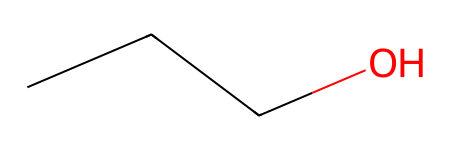

In [248]:
mol = Chem.MolFromSmiles('CCCO')
mol

If JupyterLab is a recent version, you should see a visual of [1-propanol](https://en.wikipedia.org/wiki/1-Propanol).
We will see more about what you can do with `mol` later, but the fact that your computer knew what `CCCO` means is because RDKit can read SMILES.

You can make some pretty cool pictures, for example:

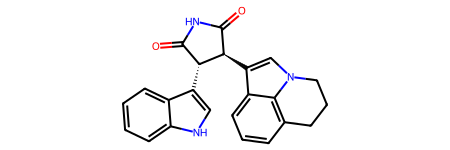

In [249]:
# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("C1CC2=C3C(=CC=C2)C(=CN3C1)[C@H]4[C@@H](C(=O)NC4=O)C5=CNC6=CC=CC=C65")
# Default
mol

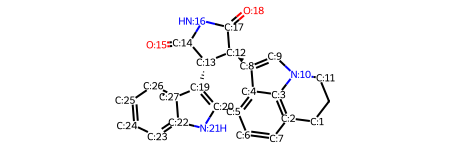

In [250]:
# With atom index
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(mol)

Now, let's parse all of the molecules. This builds the molecules from SMILES, assigning the structure given standard rules of organic chemistry. Then is stores it using Panda's map function.

In [251]:
data['mol'] = data['smiles_0'].map(Chem.MolFromSmiles)

## Part 3: Basics of Manipulating Molecules with RDKIT
Once molecules are parsed, you can make many kinds of queries about them.

For now, we use the 1-Propanol molecule from earlier as an example

### Basic Functionality
RDKit treats the molecule as a Python object and, accordingly, you can interact with it using some functions

In [252]:
for i, a in enumerate(mol.GetAtoms()):
    print(f'Atom {i} is an {a.GetSymbol()}')

Atom 0 is an C
Atom 1 is an C
Atom 2 is an C
Atom 3 is an C
Atom 4 is an C
Atom 5 is an C
Atom 6 is an C
Atom 7 is an C
Atom 8 is an C
Atom 9 is an C
Atom 10 is an N
Atom 11 is an C
Atom 12 is an C
Atom 13 is an C
Atom 14 is an C
Atom 15 is an O
Atom 16 is an N
Atom 17 is an C
Atom 18 is an O
Atom 19 is an C
Atom 20 is an C
Atom 21 is an N
Atom 22 is an C
Atom 23 is an C
Atom 24 is an C
Atom 25 is an C
Atom 26 is an C
Atom 27 is an C


Note that it initially treats the molecule with _implicit_ hydrogrens, which you can add by calling a method from the `Chem` module

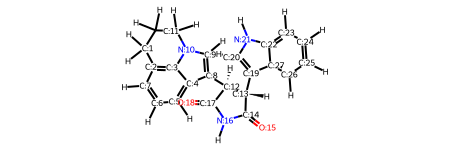

In [253]:
mol = Chem.AddHs(mol)
mol

You can also do more sophisticated things like, find all rings

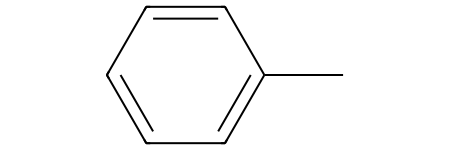

In [254]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
toluene

In [255]:
r = toluene.GetRingInfo()
print(f'Toluene has {r.NumRings()} ring')

Toluene has 1 ring


You can imagine that RDKit has many capabilities for describing molecules

### Descriptors
RDKit is a source of [many different "descriptors" for molecules](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors). We'll demonstrate a few for concepts.

Some generate `float` or `int` values, which can be directly used by Python

In [256]:
print(f'Toluene has {AllChem.CalcNumRotatableBonds(toluene)} rotatable bonds')

Toluene has 0 rotatable bonds


Others are in C++ objects which, while similar to Python objects, should be converted to a Python standard type.

*Aside*: This has to do with parts of RDKit being written in C++.

### Fingerprints
Another class of descriptor are "fingerprints," which seek to encode the entire molecule as a fixed length vector of bits. RDKit [implements a few of these](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints)

In [257]:
bv = AllChem.GetMorganFingerprintAsBitVect(mol, 4, 16)
bv

In [258]:
np.asarray(bv)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Descriptor Calculation (with Modred)
The key unit for working with Mordred is the [``Calculator``](http://mordred-descriptor.github.io/documentation/master/mordred.html#mordred.Calculator) object.

In [259]:
calc = Calculator(descriptors, ignore_3D=True)

Modred extracts many descriptors.

In [260]:
print(f'First 10 out of {len(calc.descriptors)} descriptors')
calc.descriptors[:10]

First 10 out of 1613 descriptors


(mordred.ABCIndex.ABCIndex(),
 mordred.ABCIndex.ABCGGIndex(),
 mordred.AcidBase.AcidicGroupCount(),
 mordred.AcidBase.BasicGroupCount(),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMax'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpDiam'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('LogEE'))

Modred also lets you compute these descriptors in parallel (using Python's [multiprocessing](https://docs.python.org/3/library/multiprocessing.html)) and stores them in a Pandas dataframe.

*NOTE*: This takes about 30 (280) seconds on colab for 100 (1000) data points as of 10/14/22.

In [261]:
desc = calc.pandas(data['mol'])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 106.96it/s]


In [262]:
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

Computed 1613 descriptors for 1000 molecules


In [263]:
desc.head(5)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,11.918853,2.400951,4.479823,11.918853,1.324317,3.225978,...,9.064274,58.079349,123.104799,5.595673,83,9,48.0,57.0,2.583333,1.972222
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,11.771545,2.758841,5.304876,11.771545,1.307949,3.351403,...,10.522531,63.411605,124.088815,5.908991,77,10,60.0,82.0,2.395833,1.888889
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,7.766202,2.539484,4.675877,7.766202,1.294367,2.940396,...,9.483797,56.364470,84.057515,6.004108,25,2,36.0,45.0,1.833333,1.222222
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,12.577256,2.636405,4.702841,12.577256,1.397473,3.311146,...,9.842835,61.935926,122.109550,5.309111,72,9,58.0,76.0,2.305556,1.805556
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,10.865671,2.695954,5.391908,10.865671,1.207297,3.254048,...,10.611055,42.667677,126.068080,6.635162,80,10,54.0,72.0,3.895833,1.972222


# Preprocessing Descriptors
The main issue before using all of these features for machine learning, especially on small datasets, is the need to perform feature selection. There are few issues to be concerned about which we do one at a time.


## Convert all of the values to numbers.
It just makes things easier

In [264]:
for c in desc.columns:
    desc[c] = pd.to_numeric(desc[c], errors='coerce')

## Remove constant features

In [265]:
desc.columns[desc.nunique() <= 1]
print(f'Now have {len(desc.columns)} descriptors for {len(desc)} molecules')

Now have 1613 descriptors for 1000 molecules


## Remove features that have missing values.

*Dev Note*: We use the [`isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) and [`any`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.any.html) functions from Pandas to check if any rows of each column have a null value. In many cases, you can write complex loops in Pandas as simple efficient statements. So, if you start writing a loop over a column maybe check the Pandas docs for an example before getting too far.

In [266]:
missing_values = desc.isnull().any()
print(f'Found {missing_values.sum()} columns with missing values')

Found 387 columns with missing values


In [267]:
desc = desc.loc[:, ~missing_values]  # Gets only columns that do not (~ means not) have missing values
print(f'Now have {len(desc.columns)} descriptors for {len(desc)} molecules')

Now have 1226 descriptors for 1000 molecules


## Scale features.
Here are statistics on the columns before standardization.

In [268]:
desc.sample(10, axis=1).describe()

,CIC3,ATSC3pe,AATSC0Z,ATSC0p,ATS8i,MATS4d,VSA_EState3,n7FARing,GATS2Z,ATSC2dv
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.368768e-01,-0.401532,7.488252,3.882570,143.878924,-0.101422,6.048077,0.096000,0.949356,-9.123264
std,3.157012e-01,0.745686,0.674858,0.757074,509.106936,0.184454,6.216974,0.294739,0.165817,16.696019
min,-1.332268e-15,-4.706095,4.246914,1.099986,0.000000,-0.741176,0.000000,0.000000,0.337503,-61.229917
25%,3.292481e-01,-0.763478,7.003460,3.399259,0.000000,-0.196398,0.000000,0.000000,0.841797,-20.335034
50%,4.863826e-01,-0.340677,7.555556,3.869295,0.000000,-0.092456,5.814005,0.000000,0.960959,-11.448980
75%,6.713099e-01,0.039048,7.984375,4.369859,0.000000,0.003725,9.212251,0.000000,1.070325,0.406272
max,2.440782e+00,2.323537,10.654321,6.038546,4611.235353,0.933702,27.638310,1.000000,1.418056,66.827160


We are going to use normalize with sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to adjust so that the mean is zero and the standard deviation is 1.

In [269]:
scaler = StandardScaler()
feats = scaler.fit_transform(desc)

This "scaler" object holds on to the means and scales of each feature so that we can then apply them to new data. You'll see where this is useful later.

## Remove Correlated Features
Many of the features in the dataset are strongly correlated with each other. For larger datasets, the subtle differences between different features could be helpful in building models. For smaller datasets, the strong correlations could lead to overfitting (e.g., some algorithms will learn preferrentially from the signals that are overrepresented in the model).

There are [numerous ways](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) to compress a set of features to a smaller set of the features that contain roughly the same information. We will use [Principle Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for its relative simplicity

In [270]:
pca = PCA().fit(feats)

PCA creates a new set of features that are linear combinations of the descriptors. One of the best things about PCA is that it can also show how how much of the data is explained by the new features.

Text(0, 0.5, 'Explained Variance')

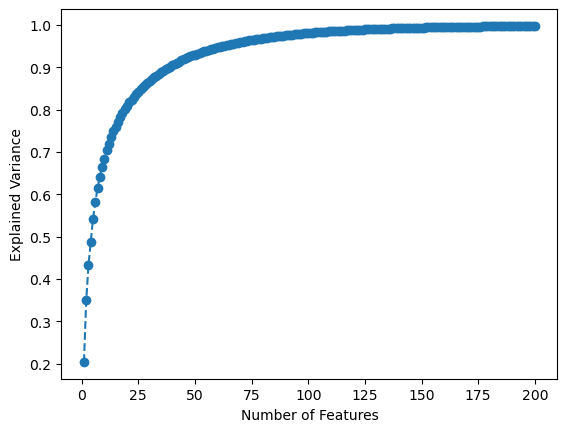

In [271]:
fig, ax = plt.subplots()

num_features = min(200,num_data_in_pandas)
ax.plot(1 + np.arange(num_features),
           np.cumsum(pca.explained_variance_ratio_)[:num_features], 'o--')

ax.set_xlabel('Number of Features')
ax.set_ylabel('Explained Variance')

Note that as we increase the number of features, we start to gradually explain more of the data.

Let's pick the number of features that explain 95% of the data for now.

Here is figure 1000 data points.
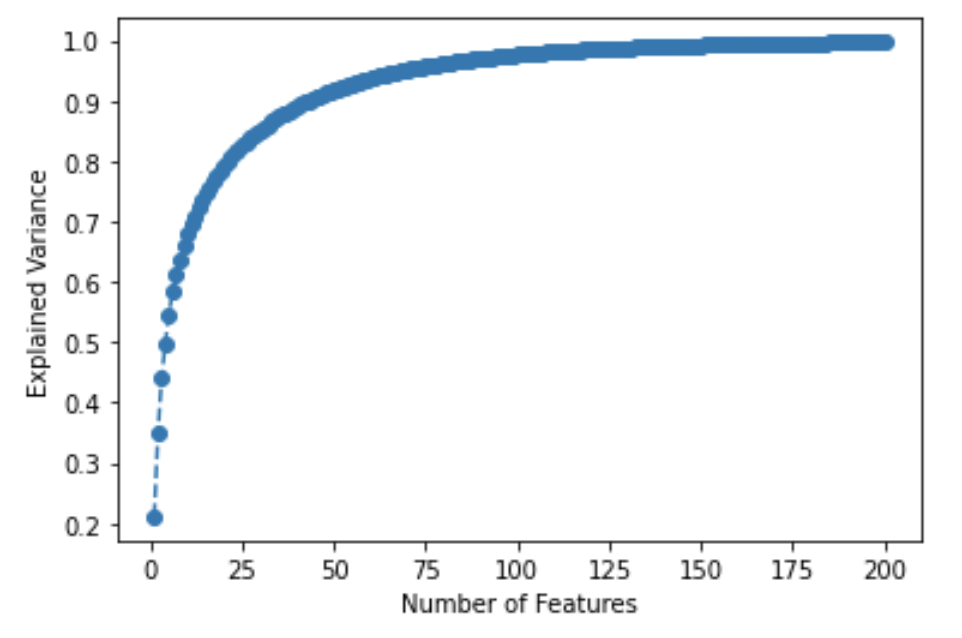

In [272]:
np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.95)

61

In [273]:
pca.n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.95)
pca_feats = pca.fit_transform(feats)
print('We are using',pca.n_components,'principal components which explain 95% of the data')

We are using 61 principal components which explain 95% of the data


# Fitting and Assessing a Model

We are going to use the pca features and fit to a target of band gap.

## LASSO Method for ML Model

For our regression model we are going to use [LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso) - a linear regression model that automatically includes only the most important features. The penalty used to determine how many features are used, $\alpha$, is a hyperparameter that must be set by experimenting with different values. Scikit-Learn has the [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) class that automatically select the best $\alpha$ for you using cross-validation.

In [274]:
lasso = LassoCV().fit(pca_feats, data['bandgap'])

In [275]:
feat_score = [np.corrcoef(data['bandgap'], f)[0][1] for f in pca_feats.T]

Text(0.5, 0, 'Feature ID')

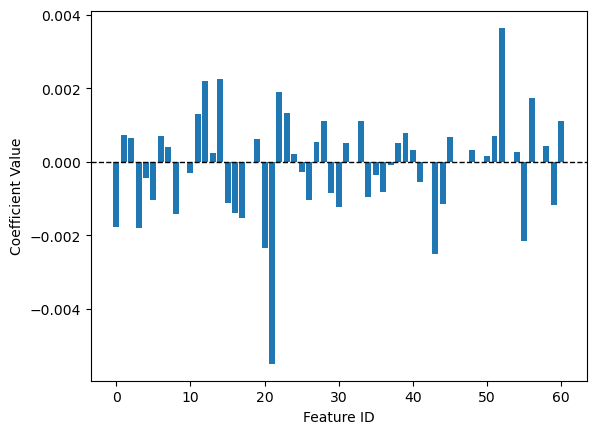

In [276]:
fig, ax = plt.subplots()

ax.bar(range(len(feat_score)), lasso.coef_)
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1.)

ax.set_ylabel(f'Coefficient Value')
ax.set_xlabel('Feature ID')

Depending on your configuration for this notebook, you may notice some of the coefficients are 0.

## Split data
We need to make a holdout test set. Note that I split both the data and the descriptors at the same time, which means the same rows (i.e., molecules) get partitioned from each array. `train_data[0]` is the same record as `train_desc[0]`. Note that in below we scale and apply LassoCV hyperparameter optimization to only training data. This avoids data leakage from test data.

In [277]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, test_size=0.2)

##Fit model

Note that here we will use the Scikit-Learn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) function to make it easier to train models that contain multiple steps. It is a fantastic tool to become familiar with because, as we will demonstrate, it makes experimenting with model settings easier.

In [278]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=pca.n_components)),
    ('lasso', LassoCV())
#    ('rf', RandomForestRegressor())
])

In [279]:
test_data = test_data.copy()  # Avoids some pandas issues
# Rerun pca to avoid notebook order issues
pca.n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.95)
pca_feats = pca.fit_transform(feats)
print('We are using',pca.n_components,'principal components which explain 95% of the data')
test_data['95-ncomp-model'] = model.fit(train_desc, train_data['bandgap']).predict(test_desc)

We are using 0 principal components which explain 95% of the data


Now, let's show how to change the PCA from 95% of data explained to 80% of data explained.

In [280]:
pca = PCA().fit(feats)
pca.n_components=np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.80)
print('We are using',pca.n_components,'principal components which explain 80% of the data')

We are using 18 principal components which explain 80% of the data


In [281]:
model.set_params(pca__n_components=pca.n_components)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=18)),
                ('lasso', LassoCV())])

In [282]:
test_data['80-ncomp-model'] = model.fit(train_desc, train_data['bandgap']).predict(test_desc)

Compare the two to each other

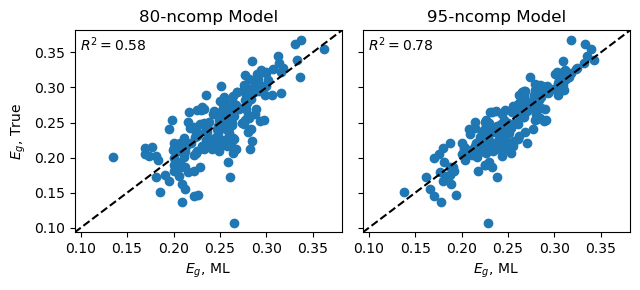

In [283]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 3.))

# Plot both models
for ax, col in zip(axs, ['80-ncomp-model', '95-ncomp-model']):
    ax.set_title(f'{col.split("-")[0]}-ncomp Model')
    r2 = r2_score(test_data['bandgap'],test_data[col])
    ax.text(0.02, 0.9, f'$R^2 = {r2:.2f}$', transform=ax.transAxes)
    ax.scatter(test_data[col], test_data['bandgap'])

# Make it look nicer
for ax in axs:
    ax.set_xlabel('$E_g$, ML')

# Make plot to show all data but may not be square
#    ax.set_ylim(ax.get_ylim())
#    ax.set_xlim(ax.get_xlim())
#   ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

# Make plot square (but may cutoff data)
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
axs[0].set_ylabel('$E_g$, True')
fig.tight_layout()

You can see that you get a better model with adding additional parameters. Here is result from 10000 data point fit.

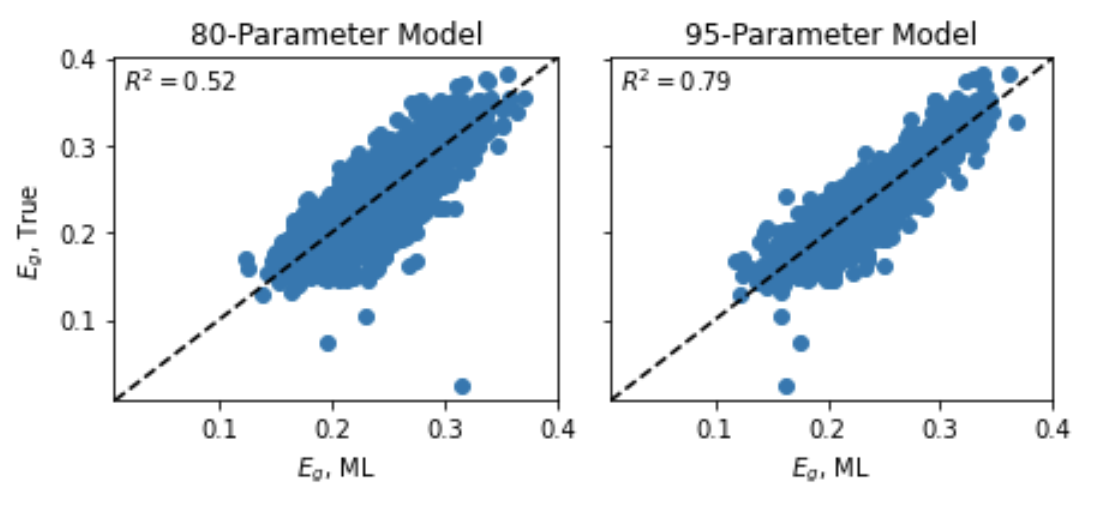

Let's also get the 5-fold cross-validation score for each pca set for bandgap. We will use sklearn's great [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) routines.

In [284]:
from sklearn.model_selection import cross_val_score
# set up our pipeline and pca items again to avoid confusion with previous notebook settings.
model = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=pca.n_components)),
    ('lasso', LassoCV())
 #    ('rf', RandomForestRegressor())
])

pca = PCA().fit(feats)
pca.n_components=np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.95)
model.set_params(pca__n_components=pca.n_components)
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='r2')
print("95-ncomp-model (%i features) 5-fold CV gave %0.2f R2 (with %0.2f standard deviation) across the 5 left out folds"
      % (pca.n_components, scores.mean(), scores.std()))
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='neg_mean_absolute_error')
print("95-ncomp-model (%i features) 5-fold CV gave %0.4f mean absolute error (with %0.4f standard deviation) across the 5 left out folds"
      % (pca.n_components, -1*scores.mean(), scores.std()))

pca = PCA().fit(feats)
pca.n_components=np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.80)
model.set_params(pca__n_components=pca.n_components)
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='r2')
print("80-ncomp-model (%i features) 5-fold CV gave %0.2f R2 (with %0.2f standard deviation) across the 5 left out folds"
      % (pca.n_components, scores.mean(), scores.std()))
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='neg_mean_absolute_error')
print("80-ncomp-model (%i features) 5-fold CV gave %0.4f mean absolut error (with %0.4f standard deviation) across the 5 left out folds"
      % (pca.n_components, -1*scores.mean(), scores.std()))

95-ncomp-model (61 features) 5-fold CV gave 0.79 R2 (with 0.02 standard deviation) across the 5 left out folds
95-ncomp-model (61 features) 5-fold CV gave 0.0168 mean absolute error (with 0.0012 standard deviation) across the 5 left out folds
80-ncomp-model (18 features) 5-fold CV gave 0.59 R2 (with 0.03 standard deviation) across the 5 left out folds
80-ncomp-model (18 features) 5-fold CV gave 0.0236 mean absolut error (with 0.0005 standard deviation) across the 5 left out folds


# Questions
Please do the following questions.  Just write the code here at the end of the notebook and turn in the notebook and output as pdf.

**Question 1:**  Determine the change in R2 and Mean Absolute Error from leaving out the PCA (at 95% explanatory level) and scaling steps for bandgap data. Use 1000 data points. If you try with lassoCV model you will see that it does not converge, which shows an immediate numerical advantage to using the PCA. But please try with Random Forest instead to see if any effects (note the Random Forest does great internal feature selection and manages scales well, so there may be no advantage, even a disadvantage, to simplifying the data with PCA). Note that random forest took about 3 minutes for each 5-fold CV for me as there are many features. You may want to remove some data and/or features while debugging.

**Question 1 Solution**

In [285]:
from sklearn.model_selection import cross_val_score
# Based on the previous tutorial
# Have PCA (at 95% explanatory level)
# Try with Random Forest
model = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=pca.n_components)),
      ('rf', RandomForestRegressor())])

# Have the PCA (at 95% explanatory level)
pca = PCA().fit(feats)
pca.n_components=np.argmax(np.cumsum(pca.explained_variance_ratio_)[:num_features]>0.95)
model.set_params(pca__n_components=pca.n_components)

# R2 and Mean Absolute Error
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='r2')
print("95-ncomp-model (%i features) 5-fold CV gave %0.2f R2 (with %0.2f standard deviation) across the 5 left out folds"
      % (pca.n_components, scores.mean(), scores.std()))
scores = cross_val_score(model, desc, data['bandgap'], cv=5, scoring='neg_mean_absolute_error')
print("95-ncomp-model (%i features) 5-fold CV gave %0.4f mean absolute error (with %0.4f standard deviation) across the 5 left out folds"
      % (pca.n_components, -1*scores.mean(), scores.std()))

95-ncomp-model (61 features) 5-fold CV gave 0.61 R2 (with 0.05 standard deviation) across the 5 left out folds
95-ncomp-model (61 features) 5-fold CV gave 0.0231 mean absolute error (with 0.0014 standard deviation) across the 5 left out folds


**Question 2:** Use Morgan (no relation to me :-)) fingerprints to predict the same properties (5-fold CV R^2 and MAE) on the same data as for Question 1. Use the same model (just random forest and no PCA). Use a 1024 feature fingerprint. I provide some code to help make the fingerprint extraction easier.

Some code for Efficiently Computing Fingerprints

We are going to make a utility class that simplifies computing fingerprints using scikit-learn's [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) class. Building a class with BaseEstimator allows it to work with some of the other functionality from scikit-learn, such as the Pipeline.

*Aside*: Read [this](https://www.w3schools.com/python/python_classes.asp) if you are unfamiliar with Python classes.

Step 1: A simple function for computing fingerprints

In [286]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [287]:
# As an example, compute methane with 6 features and radius of 4.
compute_morgan_fingerprints('C', 6, 4)

array([False, False, False, False,  True, False])

In [288]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""

    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius

    def fit(self, X, y=None):
        return self  # Do need to do anything

    def transform(self, X, y=None):
        """Compute the fingerprints

        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """

        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)

In [289]:
# As an example, compute a series of SMILES strings with 6 features and radius of 4.
m = MorganFingerprintTransformer(6, 4)
m.transform(['C', 'CCC', 'C=O'])

array([[False, False, False, False,  True, False],
       [ True, False, False,  True,  True, False],
       [False, False,  True, False,  True, False]])

That is the end of the provided code.  Please complete the analysis from here.

**Question 2 Solution**


In [290]:
# Define your model using Random Forest with Morgan fingerprints
model = Pipeline([
    ('morgan', MorganFingerprintTransformer()),
    ('rf', RandomForestRegressor())
])

# R2 and Mean Absolute Error
scores = cross_val_score(model, data['smiles_0'], data['bandgap'], cv=5, scoring='r2')
print("95-ncomp-model (%i features) 5-fold CV gave %0.2f R2 (with %0.2f standard deviation) across the 5 left out folds"
      % (pca.n_components, scores.mean(), scores.std()))
scores = cross_val_score(model, data['smiles_0'], data['bandgap'], cv=5, scoring='neg_mean_absolute_error')
print("95-ncomp-model (%i features) 5-fold CV gave %0.4f mean absolute error (with %0.4f standard deviation) across the 5 left out folds"
      % (pca.n_components, -1*scores.mean(), scores.std()))

95-ncomp-model (61 features) 5-fold CV gave 0.65 R2 (with 0.03 standard deviation) across the 5 left out folds
95-ncomp-model (61 features) 5-fold CV gave 0.0212 mean absolute error (with 0.0007 standard deviation) across the 5 left out folds
